### Import all the Dependencies

In [111]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from re import sub
from re import sub


### Set all the Constants

In [112]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)  # Set the desired image dimensions
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [113]:
dataset_directory = "CropDisease" 

In [114]:
# Create the dataset using the tf.data.Dataset API
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 1104 files belonging to 6 classes.


In [115]:
class_names = dataset.class_names
print(class_names)

['Bhutta_Healthy', 'Dhaan_Brown_Spot', 'Dhaan_Healthy', 'Dhaan_Hispa', 'Dhaan_Leaf_Blast', 'Invalid']


In [116]:
# Define the desired image dimensions (width and height)
IMG_SIZE = (150, 150)

# Set up the image data generator
image_data_generator = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values

# Load and preprocess the dataset
batch_size = 32
dataset = image_data_generator.flow_from_directory(
    dataset_directory,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

# Get a batch of images and labels
images, labels = next(dataset)

# Display the shape of the image batch and labels batch
print("Image batch shape:", images.shape)
print("Labels batch shape:", labels.shape)


# Get a batch of images and labels
images, labels = next(dataset)

Found 1104 images belonging to 6 classes.


Image batch shape: (32, 150, 150, 3)
Labels batch shape: (32, 6)


### Visualize some of the images from our dataset

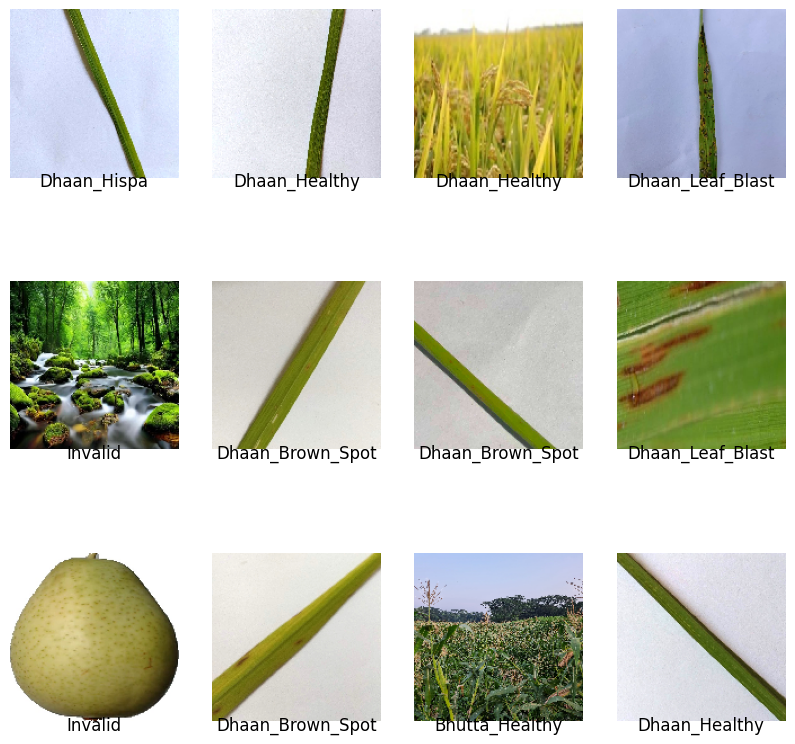

In [117]:

# Get a batch of images and labels
images, labels = next(dataset)

# Display the images
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    title = sub(r"[_]+", "_", class_names[np.argmax(labels[i])])
    plt.title(title, y=-0.1)
    plt.axis("off")

plt.show()


### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [118]:
len(dataset)

35

In [119]:
train_size = 0.8
len(dataset)*train_size

28.0

In [120]:
train_ds = 'train_dataset'
len(train_ds)

13

In [121]:
test_ds = 'test_dataset'
len(test_ds)

12

In [122]:
val_size=0.1
len(dataset)*val_size

3.5

In [123]:
val_ds = test_ds
len(val_ds)

12

In [124]:
test_ds = test_ds
len(test_ds)

12

In [125]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)   
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

In [126]:
image_batch, labels_batch = next(dataset)


In [127]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

In [128]:
len(train_ds)

28

In [129]:
len(val_ds)

3

In [130]:
len(test_ds)

4

### Cache, Shuffle, and Prefetch the Dataset

In [131]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [132]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [133]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [134]:
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)
n_classes = 6

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [135]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 17, 17, 64)      

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [136]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [137]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_4338]